## KalmanODE & KalmanODE_py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from KalmanTest.KalmanODE_py import KalmanODE_py
from probDE.Kalman.ode_init import car_init, indep_ode_init
from probDE.cython.KalmanTest.KalmanODE import KalmanODE
from probDE.utils.utils import rand_mat
from scipy.integrate import odeint

%load_ext cython

In [ ]:
from math import sin
def ode_py(x_t, t, theta=None):
    return sin(2*t) - x_t[0]

In [ ]:
# LHS vector of ODE
w_vec = np.array([0.0, 0.0, 1.0])

# These parameters define the order of the ODE and the CAR(p) process
n_meas = 1
n_state = 4

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 100
tmin = 0
tmax = 10

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = 50
sigma = .5

# Initial value, x0, for the IVP
x0 = np.array([-1., 0., 1.])

In [ ]:
# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
kinit = indep_ode_init([car_init(n_state, tau, sigma, dt, w_vec, x0)], n_state)
x0_state = kinit[-1]

# Initialize the Kalman class
kalmanode = KalmanODE.initialize(kinit, n_state, n_meas, tmin, tmax, n_eval, ode_py)
# Run the solver to get an approximation
kalman_sim = kalmanode.solve(x0_state, mv=False, sim=True)

In [ ]:
kalmanode = KalmanODE.initialize(kinit, n_state, n_meas, tmin, tmax, n_eval, ode_py) # Initialize the class
kalman_cy = %timeit -o -n 100 _ = kalmanode.solve(x0_state, mv=False, sim=True)

In [ ]:
kalmanode_py = KalmanODE_py.initialize(kinit, n_state, n_meas, tmin, tmax, n_eval, ode_py) # Initialize the class
kalman_py = %timeit -o -n 100 _, _, _ = kalmanode_py.solve(x0_state, mv=True, sim=True)

In [ ]:
kalman_py.average/kalman_cy.average

In [ ]:
from probDE.Examples.readme_graph import readme_graph
draws = 100
XXn = readme_graph(ode_py, n_state, n_meas, tmin, tmax, w_vec, x0, draws)

## Lorenz63

In [ ]:
# RHS of ODE
def lorenz(X_t, t, theta=(28, 10, 8/3)):
    rho, sigma, beta = theta
    p = 3
    x, y, z = X_t[p*0], X_t[p*1], X_t[p*2]
    return np.array([-sigma*x + sigma*y, rho*x - y -x*z, -beta*z + x*y]) 

# LHS Matrix of ODE
w_mat = np.array([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]])

# These parameters define the order of the ODE and the CAR(p) process
n_meas = 3
n_state = 9 # number of continuous derivatives of CAR(p) solution prior
n_state1 = n_state2 = n_state3 = 3
n_var_states = np.array([n_state1, n_state2, n_state3])

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 5000 
tmin = 0
tmax = 20
theta=(28, 10, 8/3)

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = np.array([1.3, 1.3, 1.3])
sigma = np.array([.5, .5, .5])
scale = 10 # Scaling factor for root generation

# Initial value, x0, for the IVP
x0 = [-12, -5, 38]
v0 = [70, 125, -124/3]
x0 = np.column_stack([x0, v0])

In [ ]:
# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
kinit = indep_ode_init([car_init(n_state1, tau[0], sigma[0], dt, w_mat[0], x0[0], scale),
                        car_init(n_state2, tau[1], sigma[1], dt, w_mat[1], x0[1], scale),
                        car_init(n_state3, tau[2], sigma[2], dt, w_mat[2], x0[2], scale)], n_state)
x0_state = kinit[-1]

# Initialize the Kalman class
kalmanode = KalmanODE.initialize(kinit, n_state, n_meas, tmin, tmax, n_eval, lorenz)
# Run the solver to get an approximation
kalman_lor_sim = kalmanode.solve(x0_state, theta, mv=False, sim=True)

In [ ]:
kalmanode = KalmanODE.initialize(kinit, n_state, n_meas, tmin, tmax, n_eval, lorenz) # Initialize the class
kalman_lor_cy = %timeit -o _ = kalmanode.solve(x0_state, theta, mv=True, sim=True)

In [ ]:
kalmanode_py = KalmanODE_py.initialize(kinit, n_state, n_meas, tmin, tmax, n_eval, lorenz) # Initialize the class
kalman_lor_py = %timeit -o _, _, _ = kalmanode_py.solve(x0_state, theta, mv=True, sim=True)

In [ ]:
kalman_lor_py.average/kalman_lor_cy.average

In [ ]:
from probDE.Examples.lorenz_graph import lorenz_graph
tau = np.array([1.3, 1.3, 1.3])
sigma = np.array([.5, .5, .5])
draws = 1000
lorenz_graph(lorenz, n_state, n_meas, tmin, tmax, n_eval, w_mat, n_var_states, tau, sigma, x0, theta, scale, draws)

## Lane-Emden

In [ ]:
def lane(x_t, t, theta=None):
    return np.array([-2/t*x_t[1] - x_t[0]**5])

# LHS vector of ODE
w_vec = np.array([0., 0., 1.])

# These parameters define the order of the ODE and the CAR(p) process
n_meas = 1
n_state = 3

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 200
tmin = 0
tmax = 10

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = 10
sigma = .001

# Initial value, x0, for the IVP
x0 = np.array([1., 0., -1.]) #Initial State

In [ ]:
# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
kinit = indep_ode_init([car_init(n_state, tau, sigma, dt, w_vec, x0)], n_state)
x0_state = kinit[-1]

# Cython
kalmanode = KalmanODE.initialize(kinit, n_state, n_meas, tmin, tmax, n_eval, lane) # Initialize the class
kalman_lane_sim = kalmanode.solve(x0_state, mv=False, sim=True)

In [ ]:
kalman_lane_cy = %timeit -o _ = kalmanode.solve(x0_state, mv=True, sim=True)

In [ ]:
kalmanode_py = KalmanODE_py.initialize(kinit, n_state, n_meas, tmin, tmax, n_eval, lane) # Initialize the class
kalman_lane_py = %timeit -o _, _, _ = kalmanode_py.solve(x0_state, mv=True, sim=True)

In [ ]:
kalman_lane_py.average/kalman_lane_cy.average

In [ ]:
from probDE.Examples.lane_graph import lane_graph
draws  = 100
lane_graph(lane, n_state, n_meas, tmin, tmax, n_eval, w_vec, tau, sigma, x0, draws)

## FitzHugh-Nagumo

- The ODE model is

    $$
    \frac{dV_t}{dt} = c(V_t - V_t^3/3 + R_t), \qquad \frac{d R_t}{dt} = -(V_t - a + b R_t)/c.
    $$

- The true parameter values are $a = .2$, $b = .2$, $c = 3$.

- The parameter priors are $\theta_j \stackrel{ind}{\sim} \mathrm{LogNormal}(\theta_{\star j}, 1)$, where $\theta_j \in \{a, b, c\}$ and $\theta_{\star j}$ is the corresponding true parameter value.

- Data is observed at time points $t = 1, 2, \ldots, 40$, with some error.  That is,

    $$
    y_{1n} \stackrel{ind}{\sim} \mathcal N(V_n, .01^2), \qquad y_{2n} \stackrel{ind}{\sim} \mathcal N(R_n, .01^2) 
    $$

- The step sizes for the discretization are $h = (.005, .01, .02, .05, .1)$.

In [2]:
from probDE.Examples.fitz import euler, Fitz, theta_plot
def fitz0(X_t, t, theta):
    "FitzHugh-Nagumo ODE function."
    a, b, c = theta
    V, R = X_t
    return np.array([c*(V - V**3/3 + R), -1/c*(V - a + b*R)])

In [3]:
# These parameters define the order of the ODE and the CAR(p) process
n_state1 = 3 # State dimension of V_n
n_state2 = 3 # State dimension of R_n
n_state = 6 # Total state
n_meas = 2 # Total measures

# it is assumed that the solution is sought on the interval [tmin, tmax].
tmin = 0 
tmax = 40
n_eval = 400

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
n_var = 2
tau = [10]*n_var
sigma = [.001]*n_var

# Initial value, a, for the IVP
theta_true = np.array([0.2, 0.2, 3]) # True theta
x0 = [-1, 1]
v0 = [1, 1/3]
x0 = np.column_stack([x0, v0])
w_mat = np.array([[0.0, 1.0], [0.0, 1.0]])

# Noise for data generation
gamma = 0.01

In [4]:
# Conrad’s setting
theta_true = np.array([.2, .2, 3]) # True theta
gamma = 0.01 # Noise for data generation
tseq = np.linspace(0, 40, num = 41) # observed data time points
X0 = [-1, 1] # initial value at time 0
X_t = odeint(fitz0, X0, tseq, args=(theta_true,)) # generate ODE
X_t = X_t[1:,:] # throw out first row, as Conrad’s example uses tau = 1, 2, …, 40
Y_t = X_t + np.random.default_rng().normal(0.0, gamma, X_t.shape) # ODE + noise

In [ ]:
theta0 = np.array([0.1, 0.1, 2.6]) # Initial theta
theta_true = np.array([.2, .2, 3]) # True theta
n_theta = len(theta0)
theta_sd = np.ones(n_theta) # lognormal theta variance
rwsd = np.array([.01, .01, .01]) # Variance of proposal generation
n_eval = 400
start_ind = n_eval//tmax
n_samples = 500

# Initialize Fitz class and get MCMC posterior
fitz = Fitz(n_state1, n_state2, n_state, n_meas)
Theta = fitz.mwg(n_samples, Y_t, start_ind, tmin, tmax, n_eval, w_mat, x0, theta0, 
                 theta_true, theta_sd, gamma, tau, sigma, rwsd)

In [ ]:
n_samples = 10000
fitz = Fitz(n_state1, n_state2, n_state, n_meas)
kalman_fitz_cy2 = %timeit -o -n1 -r1 _=  \
fitz.mwg(n_samples, Y_t[:, [0, 3]], tmin, tmax, n_eval, w_mat, x0, theta0, theta_true, theta_sd, gamma, tau, sigma, rwsd)

In [ ]:
n_runs = 10
n_eval = 800
kfitz_Xt = np.zeros((n_runs, n_eval+1, 2))
fitz = Fitz(n_state1, n_state2, n_state, n_meas)
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
tseq = np.linspace(tmin, tmax, n_eval+1)
ofitz_Xt = odeint(fitz0, [-1, 1], tseq, args=(theta_true,))
for i in range(10):
    _, X_t = fitz.simulate(tmin, tmax, n_eval, x0, theta_true, tau, sigma, w_mat, gamma, .1)
    kfitz_Xt[i] = X_t[:, [0, 3]]
    for j in range(2):
        axs[j].plot(tseq, kfitz_Xt[i, :, j])
for i in range(2):
    axs[i].plot(tseq, ofitz_Xt[:, i], color='r', label='odeint')
    axs[i].legend(loc='upper left')

## Fitz Contour Plots

In [6]:
h = np.array([.1, .05, .02, .01, .005]) 
n_h = len(h)
h_eval = 40/h # Step size
h_eval = h_eval.astype(int)

In [7]:
theta0 = np.array([.25, .25, 2.5])
theta_true = np.array([.2, .2, 3.])
n_theta = len(theta0)
theta_sd = np.ones(n_theta) # lognormal theta variance
rwsd = np.array([.001, .001, .01])
n_samples = 1000
fitz_theta = np.zeros((n_h, n_samples, n_theta))
fitz = Fitz(n_state1, n_state2, n_state, n_meas)
for i in range(n_h):
    start_ind = int(1/h[i])
    Theta = fitz.mwg(n_samples, Y_t, start_ind, tmin, tmax, h_eval[i], w_mat, x0, theta0, 
                     theta_true, theta_sd, gamma, tau, sigma, rwsd)
    fitz_theta[i] = Theta

In [9]:
theta0 = np.array([.1, .1, 2.5])
theta_true = np.array([.2, .2, 3.])
rwsd = np.array([.01, .01, .01])
n_samples = 500
fitz_det_theta = np.zeros((n_h, n_samples, n_theta))
fitz = Fitz(n_state1, n_state2, n_state, n_meas)
for i in range(n_h):
    Theta_det = fitz.mwg_det(n_samples, Y_t, h[i], h_eval[i], w_mat, x0[0], theta0, 
                             theta_true, theta_sd, gamma, rwsd)
    fitz_det_theta[i] = Theta_det

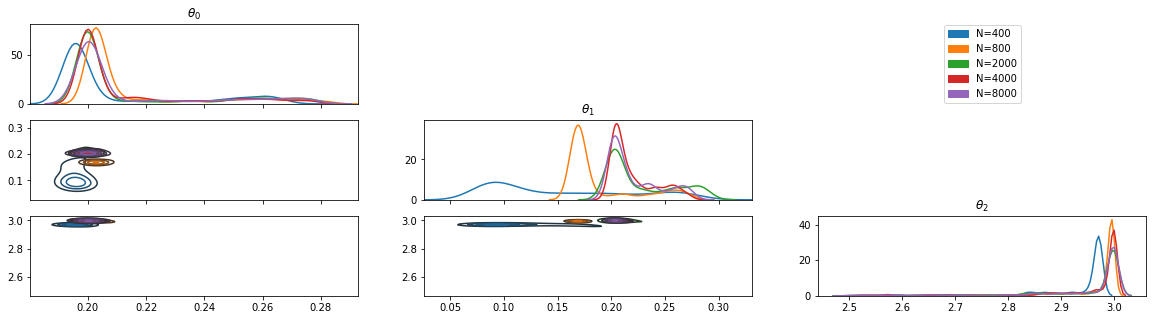

In [13]:
theta_plot(fitz_theta, h_eval, 4)

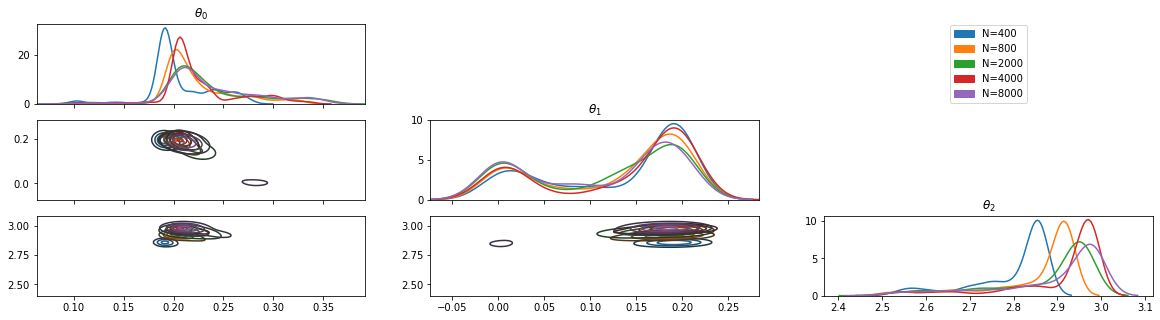

In [14]:
theta_plot(fitz_det_theta, h_eval, 4)